# Problem Parameters

In [23]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import warnings

# Parameters
k_a = 1  # Fitness gain factor
k_f = 2  # Fatigue accumulation factor
tau_a = 45  # Fitness decay constant
tau_f = 12   # Fatigue recovery constant
eta = 0.1   # Sensitivity of performance to fatigue
T = 170    # Time from beginning of training to Ivy League Championships (peak)
p_desired = 1.5  # Arbitrary desired performance

# Discretize the state space and time horizon

In [24]:
# State and time grid
n_g, n_h, n_t = 50, 50, 170  # Number of grid points for g, h, and t
g_max, h_max = 2.0, 1.5  # Max fitness and fatigue 
g_grid = np.linspace(0, g_max, n_g)
h_grid = np.linspace(0, h_max, n_h)
t_grid = np.linspace(0, T, n_t)

# Value function and optimal w storage
V = np.full((n_g, n_h, n_t), np.inf)
W_opt = np.zeros((n_g, n_h, n_t))  # To store optimal w(t)

# Terminal condition for V at t = T
for i in range(n_g):
    for j in range(n_h):
        g, h = g_grid[i], h_grid[j]
        p = g * np.exp(-eta * h)
        V[i, j, -1] = p - p_desired

# Solve $V(g,h,t)$ and $w_{opt}(t)$ in time

In [25]:
# Time step size
dt = T / (n_t - 1)
dg = g_grid[1] - g_grid[0]
dh = h_grid[1] - h_grid[0]

# HJB solver
# Forward computation of the value function and optimal control
for t_idx in range(0, n_t - 1):  # Start from t = 0
    for i in range(1, n_g - 1):  # 
        for j in range(1, n_h- 1):  # 
            # Gradients of V
            dV_dg = (V[i+1, j, t_idx] - V[i, j, t_idx]) / dg  # Forward difference in g
            dV_dh = (V[i, j+1, t_idx] - V[i, j, t_idx]) / dh  # Forward difference in h
            grad_V = np.array([dV_dg, dV_dh])

            # Hamiltonian components
            def F1(w): return k_a * h_grid[j] * (1 - w) - g_grid[i] / tau_a
            def F2(w): return k_f * w - h_grid[j] / tau_f

            # Maximize H to find optimal w
            w_opt = max(0, min(1, (grad_V[1] * k_f - grad_V[0] * k_a * h_grid[j]) / 2))
            W_opt[i, j, t_idx] = w_opt  # Store optimal w

            # Compute the dynamics using w_opt
            F = np.array([F1(w_opt), F2(w_opt)])
            C = w_opt**2  # Quadratic cost of training load

            # Update value function
            V[i, j, t_idx] = V[i, j, t_idx+1] + dt * (grad_V @ F - C)
            warnings.filterwarnings("ignore", category=RuntimeWarning)

# Interpolate
The interpolation function takes any $g,h,t$ as input and returns the corresponding $w_{opt}(g,h,t)$ by interpolating between the grid points.

In [26]:
# Interpolator for w_opt
interpolate_w_opt = RegularGridInterpolator((g_grid, h_grid, t_grid), W_opt, bounds_error=False, fill_value=0)

# Simulate $g(t)$, $h(t)$, and $p(t)$ forward in time starting from initial conditions

In [27]:
# Forward simulation of dynamics
def forward_dynamics(t, y):
    g, h = y
    w_t = interpolate_w_opt((g, h, t)) 
    mu = k_a / (k_f * tau_f)
    dg_dt = mu * h * (1 - w_t) - g / tau_a
    dh_dt = k_f * w_t - h / tau_f
    return [dg_dt, dh_dt]

# Initial conditions
g0, h0 = 1.0, 0.5  # Starting fitness and fatigue
y0 = [g0, h0]

# Time points for forward simulation
t_eval = np.linspace(0, T, 1000)

# Solve forward dynamics
solution = solve_ivp(forward_dynamics, (0, T), y0, t_eval=t_eval)
time = solution.t
g = solution.y[0]
h = solution.y[1]

# Compute performance
p = g * np.exp(-eta * h)

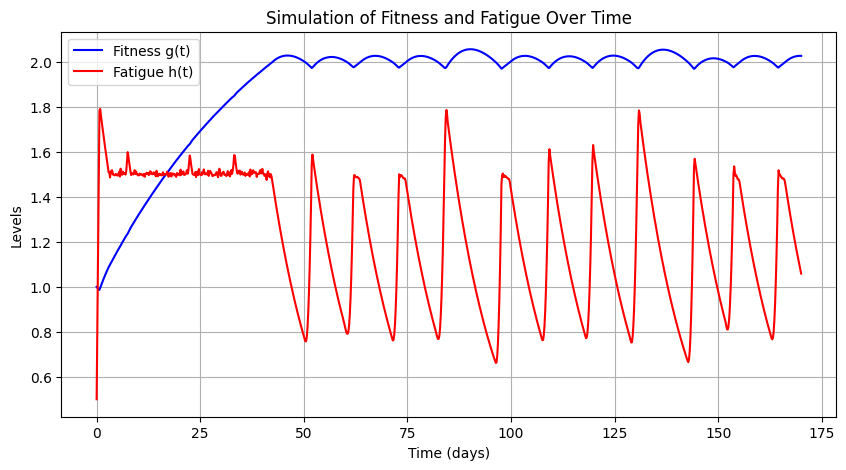

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(time, g, label="Fitness g(t)", color="blue")
plt.plot(time, h, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time")
plt.legend()
plt.grid()
plt.show()

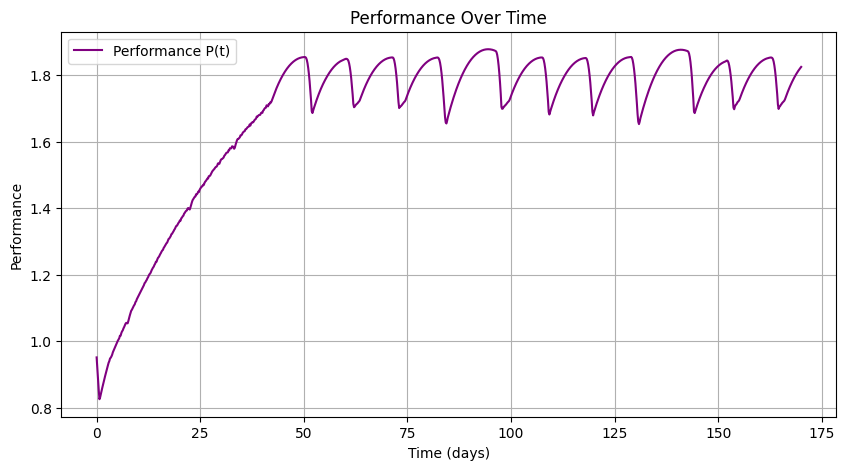

In [29]:
def plot_performance(time, g, h, eta=0.1):
    p = g * np.exp(-eta * h)

    # Plot performance
    plt.figure(figsize=(10, 5))
    plt.plot(time, p, label="Performance P(t)", color="purple")
    plt.xlabel("Time (days)")
    plt.ylabel("Performance")
    plt.title("Performance Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_performance(time, g, h)

# Fast Fourier Transformation

In [30]:
from scipy.fft import fft, fftfreq
def plot_fft_of_performance(time, performance, label, start_time=20, max_period=60):
    # Trim to ignore early transients
    mask = time >= start_time
    t_trimmed = time[mask]
    p_trimmed = performance[mask]

    if len(p_trimmed) < 2:
        raise ValueError("Not enough data points after start_time for FFT.")

    # FFT setup
    T_s = t_trimmed[1] - t_trimmed[0]
    N = len(p_trimmed)
    yf = fft(p_trimmed - np.mean(p_trimmed))
    xf = fftfreq(N, T_s)[:N//2]
    magnitude = 2.0/N * np.abs(yf[0:N//2])

    # Convert to period (days per cycle), filter out very high or low periods
    nonzero_freqs = xf > 0
    periods = 1 / xf[nonzero_freqs]
    magnitudes = magnitude[nonzero_freqs]

    # Filter to meaningful periods
    mask = periods <= max_period
    periods = periods[mask]
    magnitudes = magnitudes[mask]

    # Plot period vs amplitude
    plt.figure(figsize=(10, 5))
    plt.plot(periods, magnitudes)
    plt.title(f'FFT of Performance — {label}')
    plt.xlabel('Period (days per cycle)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    idx_max = np.argmax(magnitudes)
    dominant_period = periods[idx_max]
    print(f"Dominant cycle length: {dominant_period:.2f} days")

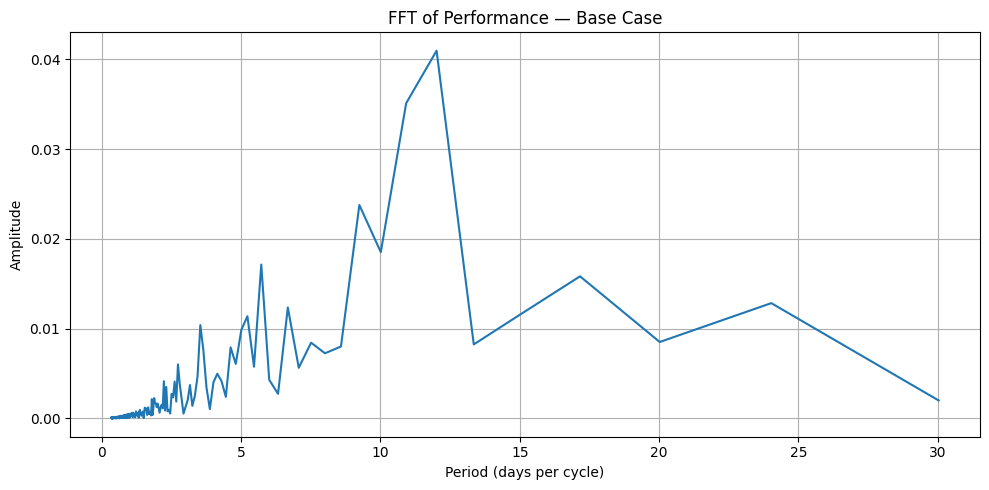

Dominant cycle length: 12.01 days


In [31]:
plot_fft_of_performance(t_eval, p, label='Base Case', start_time=50, max_period=40)

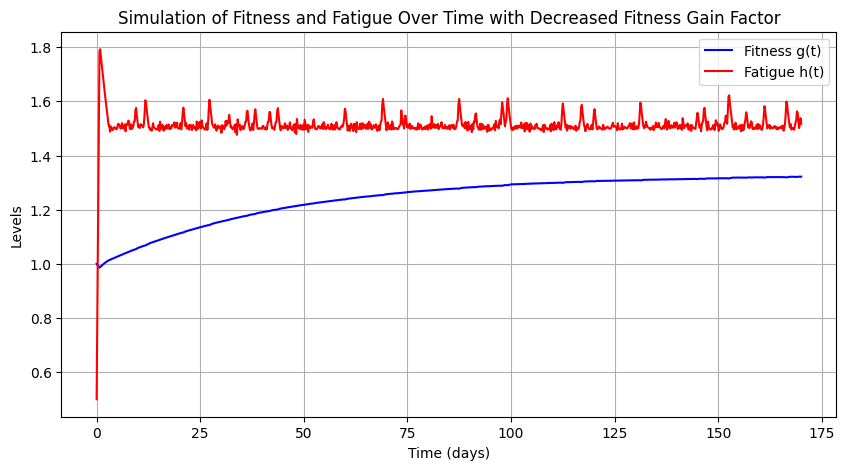

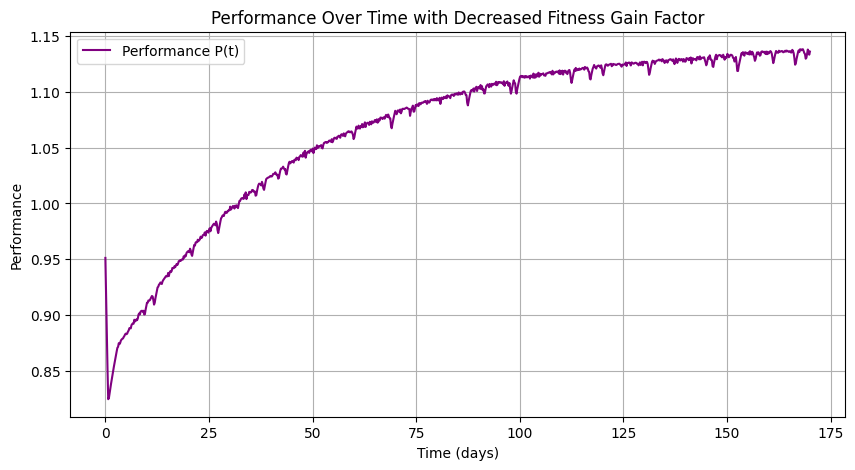

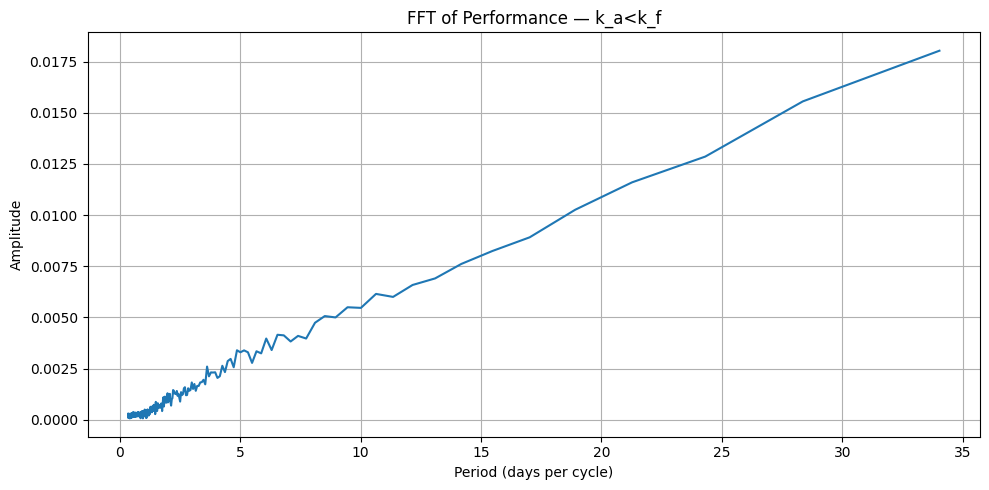

Dominant cycle length: 34.03 days


In [32]:
# Decrease Fitness Gain Factor 
def forward_dynamics_with_optimal_w(t, y, k_a, k_f, tau_a, tau_f, eta, interpolate_w_opt):
    g, h = y
    w_t = interpolate_w_opt((g, h, t))  
    mu = k_a / (k_f * tau_f)
    dg_dt = mu * h * (1 - w_t) - g / tau_a
    dh_dt = k_f * w_t - h / tau_f
    return [dg_dt, dh_dt]
    
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    0.5, 2, 45, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Decreased Fitness Gain Factor")
plt.legend()
plt.grid(True)
plt.show()

p = g_opt * np.exp(-eta * h_opt)
plt.figure(figsize=(10, 5))
plt.plot(time_opt, p, label="Performance P(t)", color="purple")
plt.xlabel("Time (days)")
plt.ylabel("Performance")
plt.title("Performance Over Time with Decreased Fitness Gain Factor")
plt.legend()
plt.grid(True)
plt.show()

# No dominant period of oscillations, not meaningful
plot_fft_of_performance(t_eval, p, label='k_a<k_f', start_time=0, max_period=40)

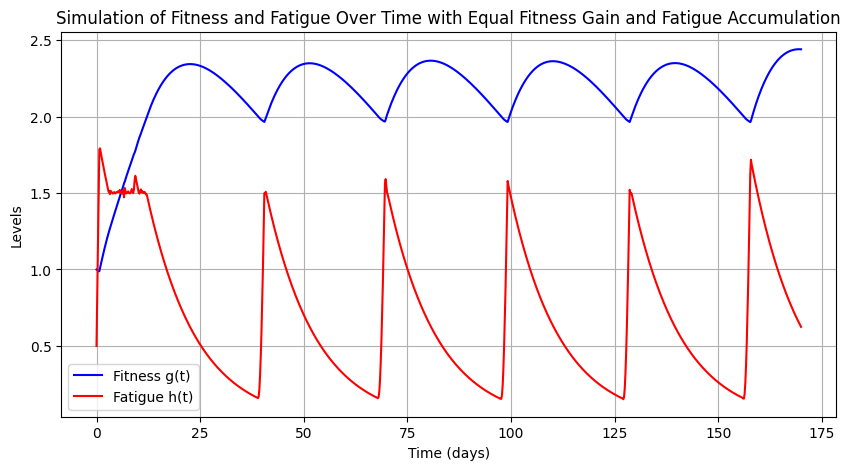

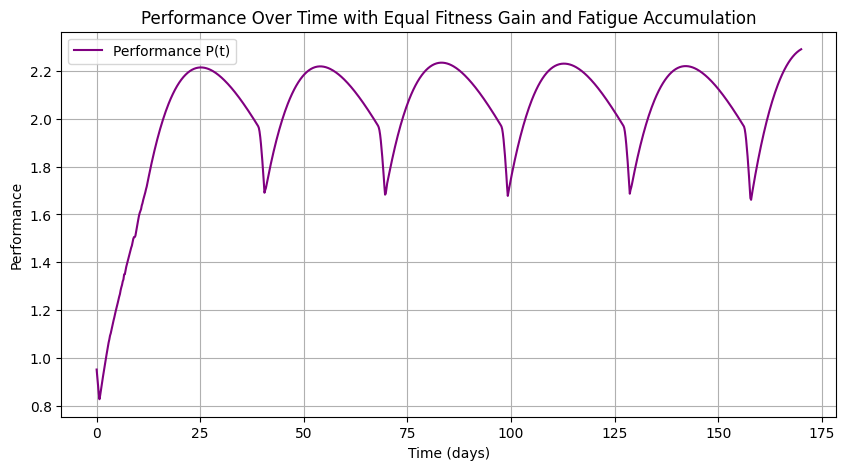

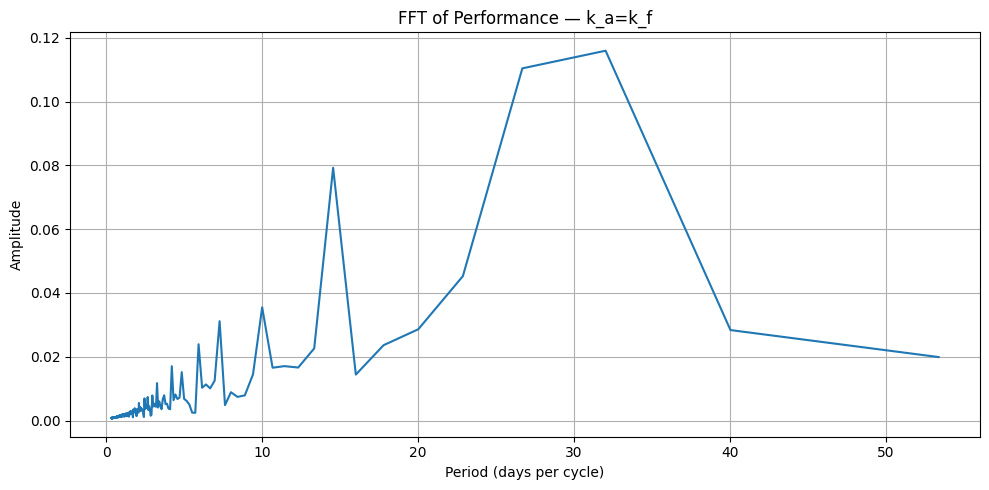

Dominant cycle length: 32.03 days


In [33]:
# Increased Fitness Gain Factor to Equal Fatigue Accumulation
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    2, 2, 45, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Equal Fitness Gain and Fatigue Accumulation")
plt.legend()
plt.grid(True)
plt.show()

p = g_opt * np.exp(-eta * h_opt)
plt.figure(figsize=(10, 5))
plt.plot(time_opt, p, label="Performance P(t)", color="purple")
plt.xlabel("Time (days)")
plt.ylabel("Performance")
plt.title("Performance Over Time with Equal Fitness Gain and Fatigue Accumulation")
plt.legend()
plt.grid(True)
plt.show()

plot_fft_of_performance(t_eval, p, label='k_a=k_f', start_time=10, max_period=60)

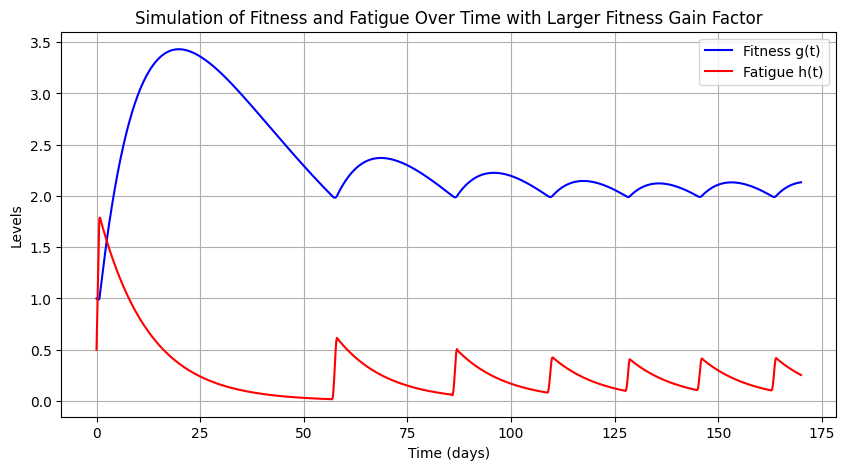

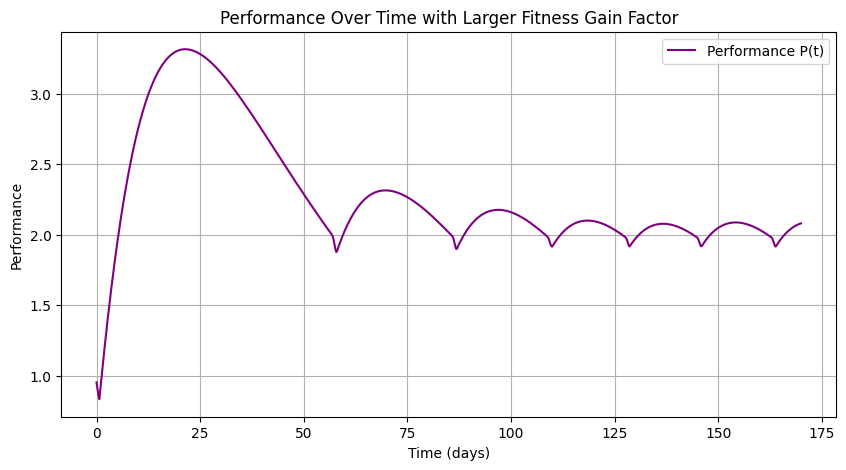

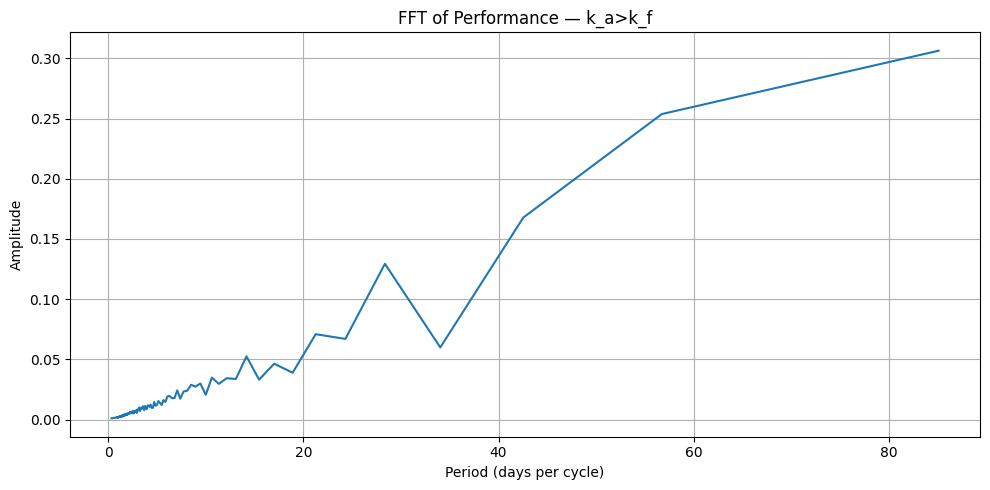

Dominant cycle length: 85.09 days


In [34]:
# Fitness Gain Factor Greater than fatigue accumulation
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    5, 2, 45, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Larger Fitness Gain Factor")
plt.legend()
plt.grid(True)
plt.show()

p = g_opt * np.exp(-eta * h_opt)
plt.figure(figsize=(10, 5))
plt.plot(time_opt, p, label="Performance P(t)", color="purple")
plt.xlabel("Time (days)")
plt.ylabel("Performance")
plt.title("Performance Over Time with Larger Fitness Gain Factor")
plt.legend()
plt.grid(True)
plt.show()

plot_fft_of_performance(t_eval, p, label='k_a>k_f', start_time=0, max_period=90)

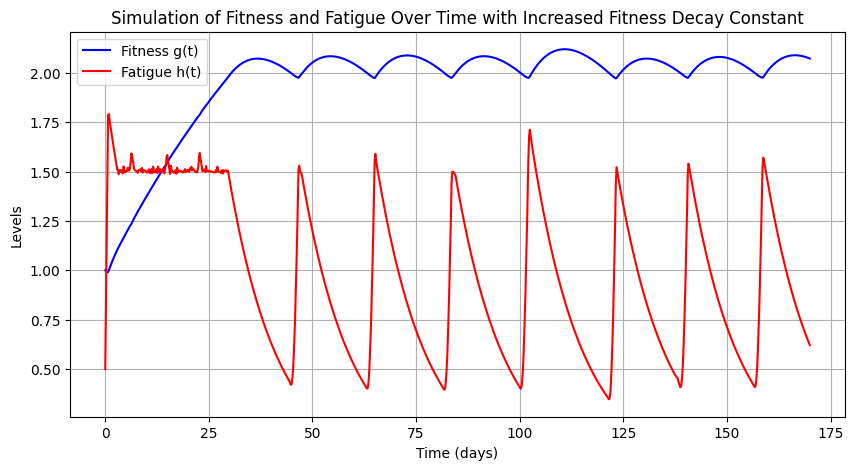

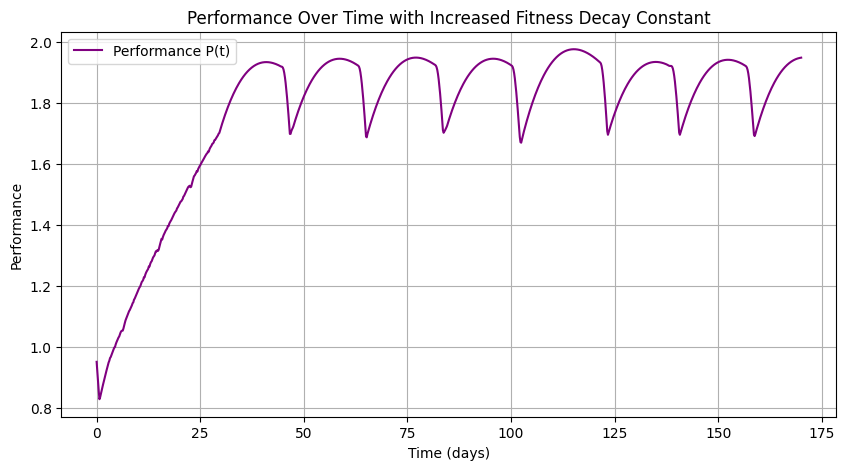

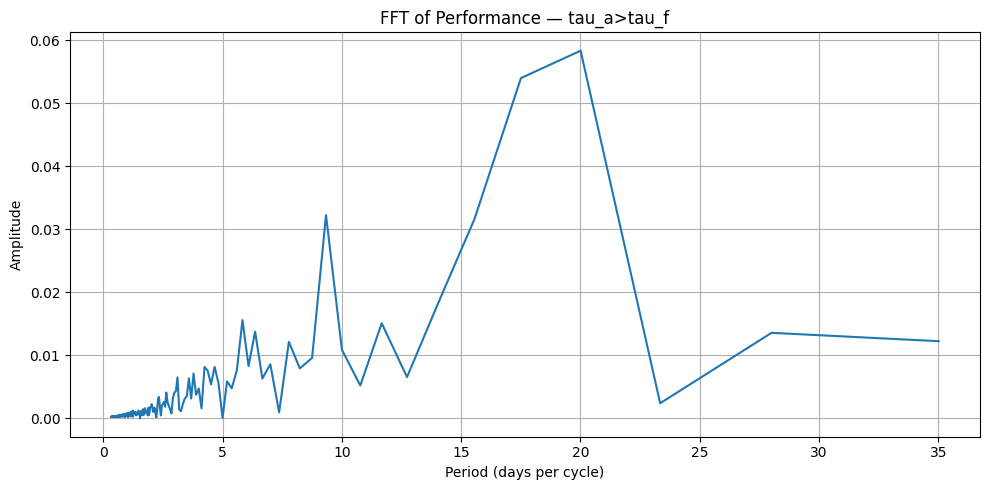

Dominant cycle length: 20.01 days


In [35]:
# Increase Fitness Decay Constant 
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    1, 2, 60, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Increased Fitness Decay Constant")
plt.legend()
plt.grid(True)
plt.show()

p = g_opt * np.exp(-eta * h_opt)
plt.figure(figsize=(10, 5))
plt.plot(time_opt, p, label="Performance P(t)", color="purple")
plt.xlabel("Time (days)")
plt.ylabel("Performance")
plt.title("Performance Over Time with Increased Fitness Decay Constant")
plt.legend()
plt.grid(True)
plt.show()

plot_fft_of_performance(t_eval, p, label='tau_a>tau_f', start_time=30, max_period=40)

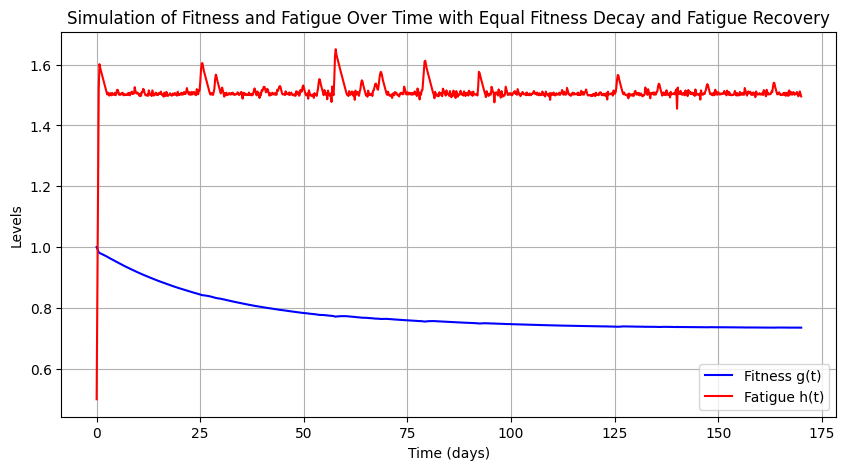

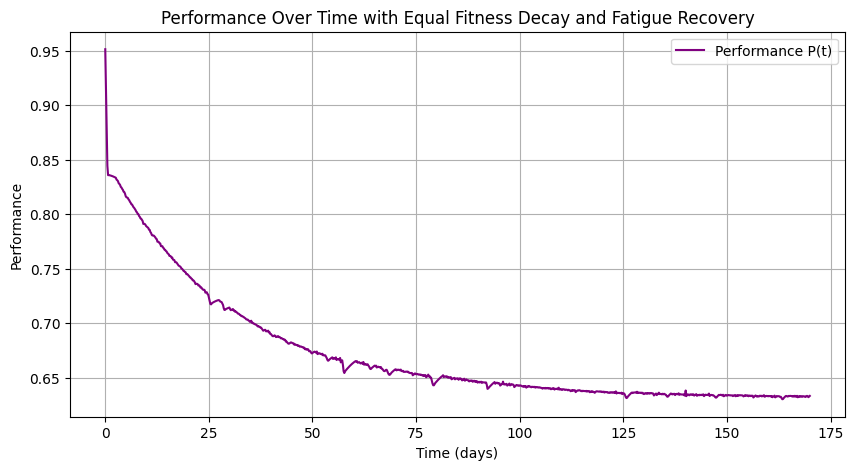

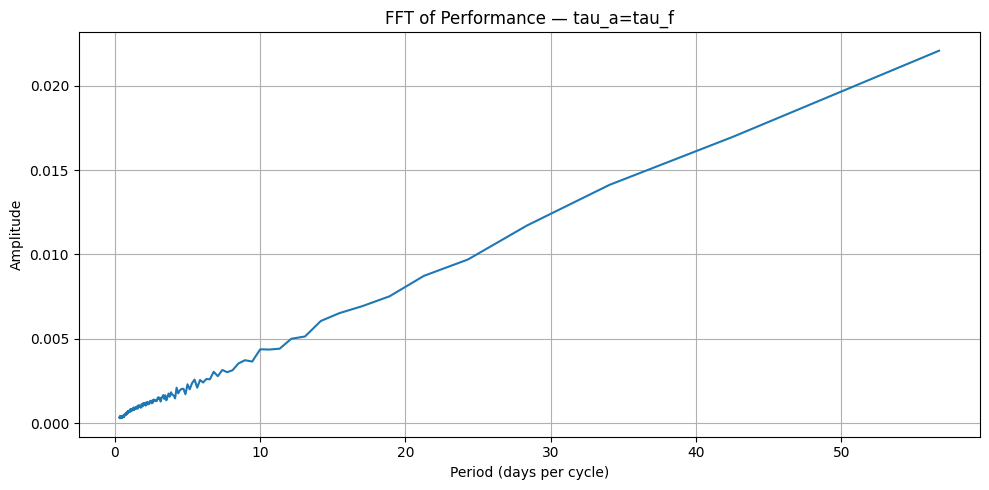

Dominant cycle length: 56.72 days


In [36]:
# Fitness Decay Constant same as fatigue recovery constant
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    1, 2, 30, 30, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Equal Fitness Decay and Fatigue Recovery")
plt.legend()
plt.grid(True)
plt.show()

p = g_opt * np.exp(-eta * h_opt)
plt.figure(figsize=(10, 5))
plt.plot(time_opt, p, label="Performance P(t)", color="purple")
plt.xlabel("Time (days)")
plt.ylabel("Performance")
plt.title("Performance Over Time with Equal Fitness Decay and Fatigue Recovery")
plt.legend()
plt.grid(True)
plt.show()

# No oscillations, so not meaningful
plot_fft_of_performance(t_eval, p, label='tau_a=tau_f', start_time=0, max_period=60)

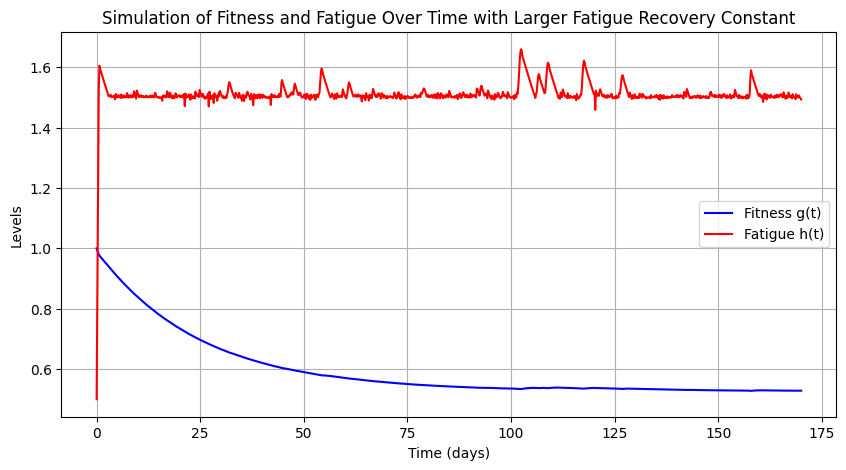

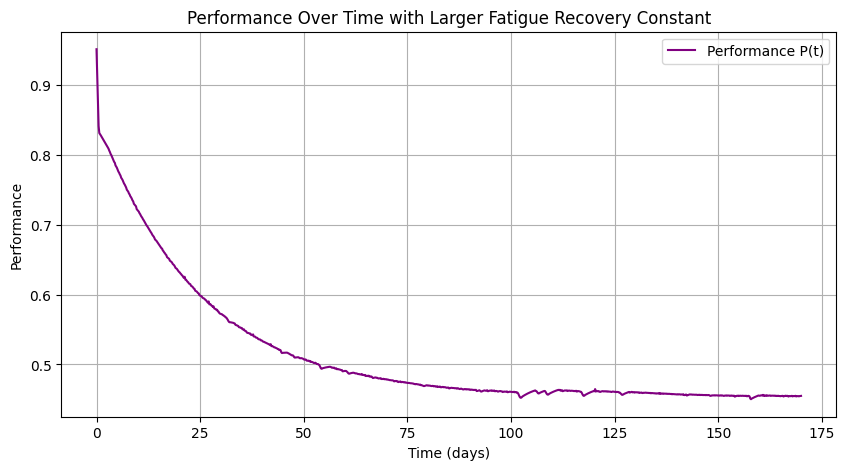

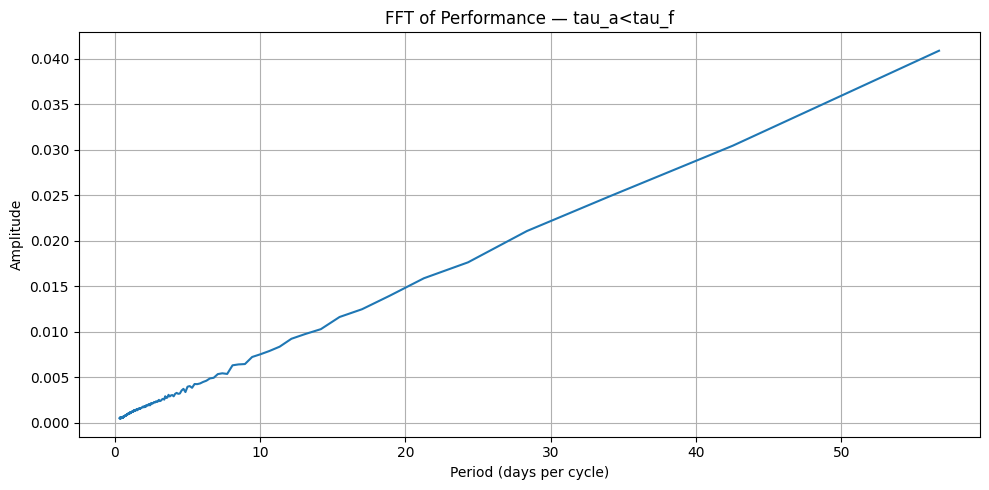

Dominant cycle length: 56.72 days


In [37]:
# Fitness Decay Constant less than fatigue recovery constant
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    1, 2, 25, 35, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Larger Fatigue Recovery Constant")
plt.legend()
plt.grid(True)
plt.show()

p = g_opt * np.exp(-eta * h_opt)
plt.figure(figsize=(10, 5))
plt.plot(time_opt, p, label="Performance P(t)", color="purple")
plt.xlabel("Time (days)")
plt.ylabel("Performance")
plt.title("Performance Over Time with Larger Fatigue Recovery Constant")
plt.legend()
plt.grid(True)
plt.show()

plot_fft_of_performance(t_eval, p, label='tau_a<tau_f', start_time=0, max_period=60)

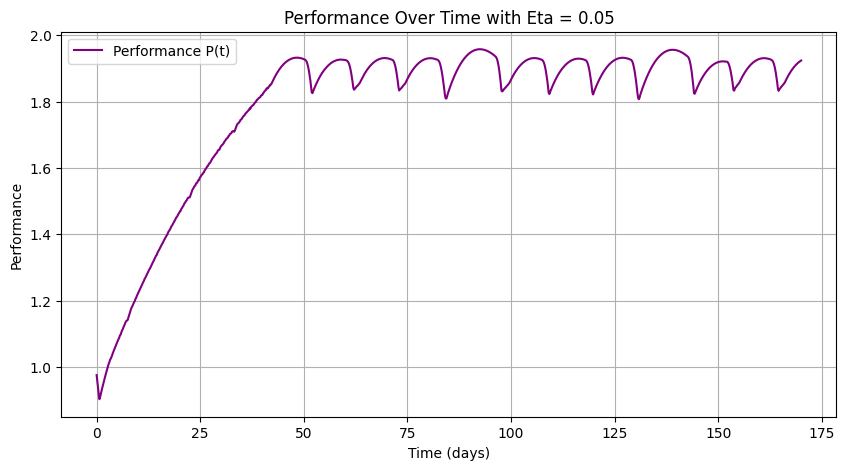

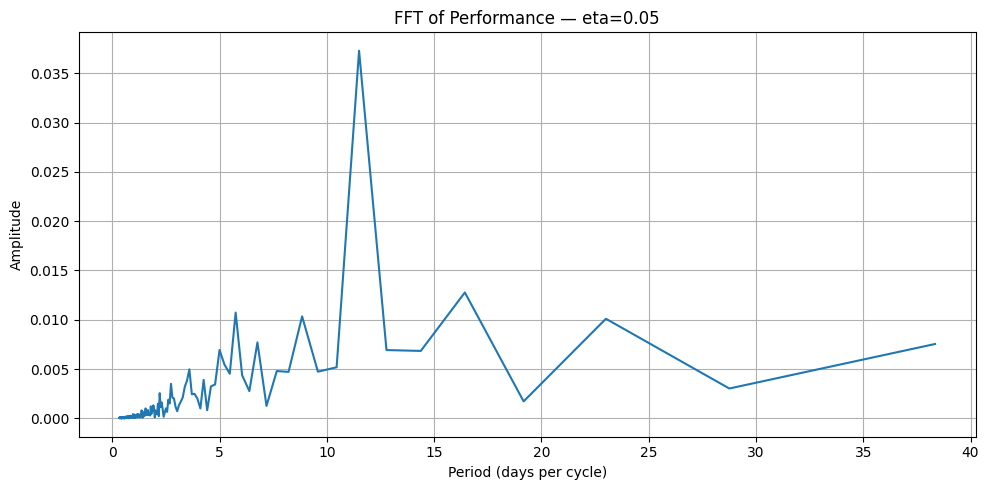

Dominant cycle length: 11.50 days


In [38]:
# eta = 0.05
eta = 0.05
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    1, 2, 45, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

def plot_performance(time, g, h, eta=0.05):
    p = g * np.exp(-eta * h)
    # Plot performance
    plt.figure(figsize=(10, 5))
    plt.plot(time, p, label="Performance P(t)", color="purple")
    plt.xlabel("Time (days)")
    plt.ylabel("Performance")
    plt.title("Performance Over Time with Eta = 0.05")
    plt.legend()
    plt.grid(True)
    plt.show()

p = g_opt * np.exp(-eta * h_opt)
plot_performance(time_opt, g_opt, h_opt)

plot_fft_of_performance(time_opt, p, label='eta=0.05', start_time=55, max_period=40)

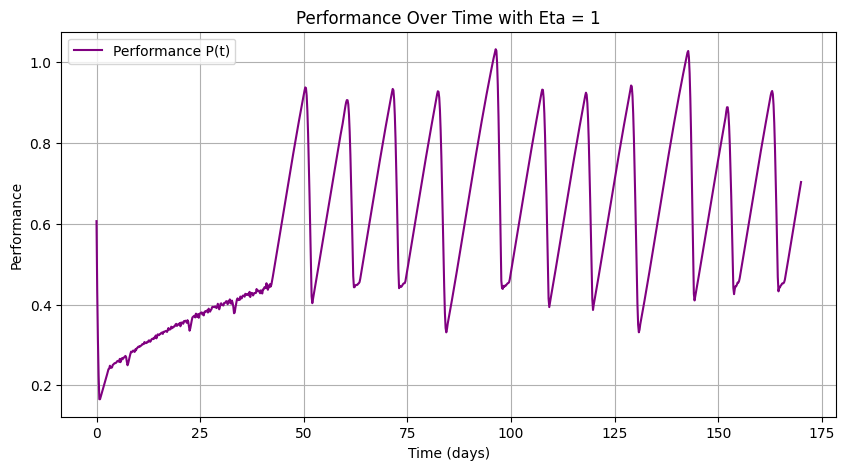

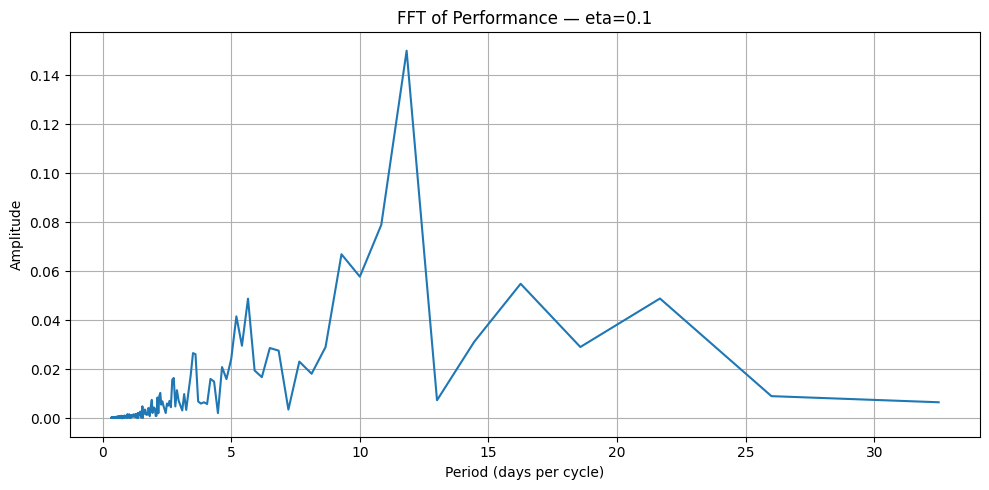

Dominant cycle length: 11.82 days


In [39]:
# eta = 1 
eta = 1
solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    1, 2, 45, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

def plot_performance(time, g, h, eta=1):
    p = g * np.exp(-eta * h)

    # Plot performance
    plt.figure(figsize=(10, 5))
    plt.plot(time, p, label="Performance P(t)", color="purple")
    plt.xlabel("Time (days)")
    plt.ylabel("Performance")
    plt.title("Performance Over Time with Eta = 1")
    plt.legend()
    plt.grid(True)
    plt.show()

p = g_opt * np.exp(-eta * h_opt)
plot_performance(time_opt, g_opt, h_opt)

plot_fft_of_performance(time_opt, p, label='eta=0.1', start_time=40, max_period=40)

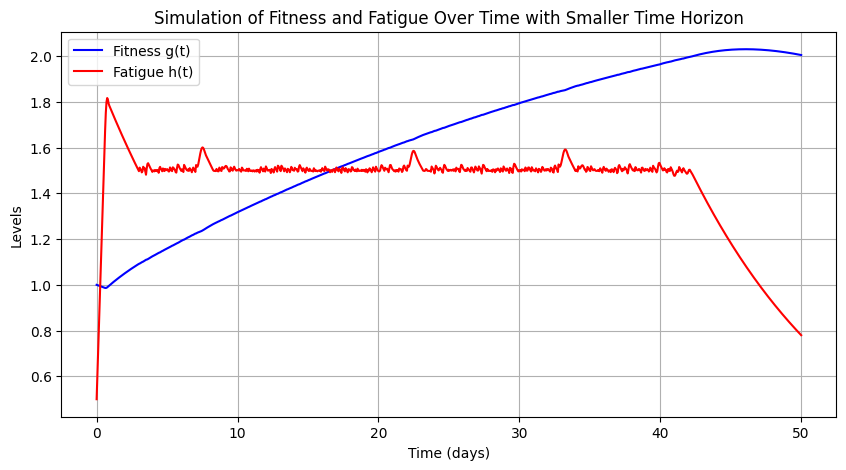

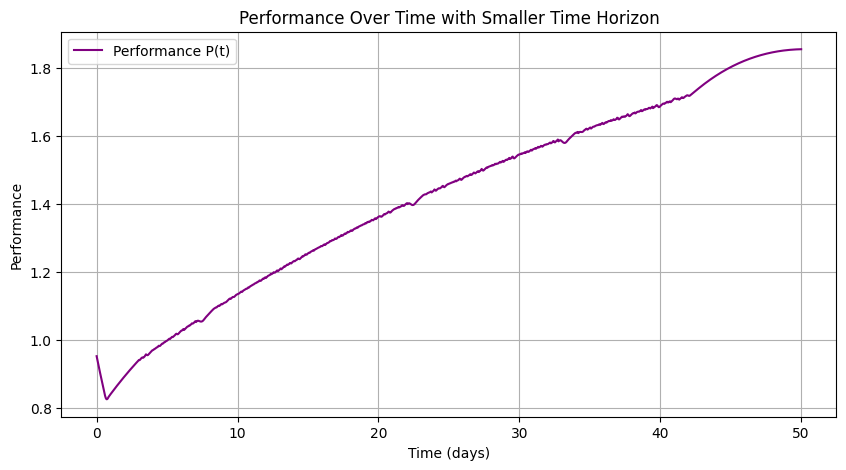

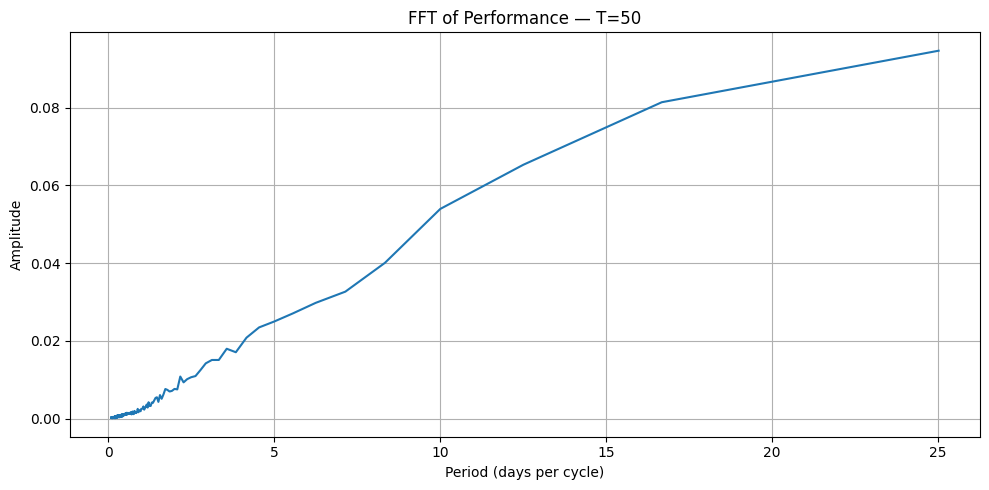

Dominant cycle length: 25.03 days


In [40]:
# Time
T = 50
n_g, n_h, n_t = 50, 50, 50
t_grid = np.linspace(0, T, n_t)
t_eval = np.linspace(0, T, 1000)

for i in range(n_g):
    for j in range(n_h):
        g, h = g_grid[i], h_grid[j]
        p = g * np.exp(-eta * h)
        V[i, j, -1] = p - p_desired


dt = T / (n_t - 1)
dg = g_grid[1] - g_grid[0]
dh = h_grid[1] - h_grid[0]

# HJB solver
for t_idx in range(0, n_t - 1):  # Start from t = 0
    for i in range(1, n_g - 1):  # 
        for j in range(1, n_h- 1):  # 
            # Gradients of V
            dV_dg = (V[i+1, j, t_idx] - V[i, j, t_idx]) / dg  # Forward difference in g
            dV_dh = (V[i, j+1, t_idx] - V[i, j, t_idx]) / dh  # Forward difference in h
            grad_V = np.array([dV_dg, dV_dh])

            # Hamiltonian components
            def F1(w): return k_a * h_grid[j] * (1 - w) - g_grid[i] / tau_a
            def F2(w): return k_f * w - h_grid[j] / tau_f

            # Maximize H to find optimal w
            w_opt = max(0, min(1, (grad_V[1] * k_f - grad_V[0] * k_a * h_grid[j]) / 2))
            W_opt[i, j, t_idx] = w_opt  # Store optimal w

            # Compute the dynamics using w_opt
            F = np.array([F1(w_opt), F2(w_opt)])
            C = w_opt**2  # Quadratic cost of training load

            # Update value function
            V[i, j, t_idx] = V[i, j, t_idx+1] + dt * (grad_V @ F - C)


def forward_dynamics_with_optimal_w(t, y, k_a, k_f, tau_a, tau_f, eta, interpolate_w_opt):
    g, h = y
    w_t = interpolate_w_opt((g, h, t))  
    mu = k_a / (k_f * tau_f)
    dg_dt = mu * h * (1 - w_t) - g / tau_a
    dh_dt = k_f * w_t - h / tau_f
    return [dg_dt, dh_dt]

solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    1, 2, 45, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Smaller Time Horizon")
plt.legend()
plt.grid(True)
plt.show()

def plot_performance(time, g, h, eta=.1):
    p = g * np.exp(-eta * h)

    # Plot performance
    plt.figure(figsize=(10, 5))
    plt.plot(time, p, label="Performance P(t)", color="purple")
    plt.xlabel("Time (days)")
    plt.ylabel("Performance")
    plt.title("Performance Over Time with Smaller Time Horizon")
    plt.legend()
    plt.grid(True)
    plt.show()
    
p = g_opt * np.exp(-eta * h_opt)
plot_performance(time_opt, g_opt, h_opt)

# No oscillations, not meaningful
plot_fft_of_performance(time_opt, p, label='T=50', start_time=0, max_period=40)

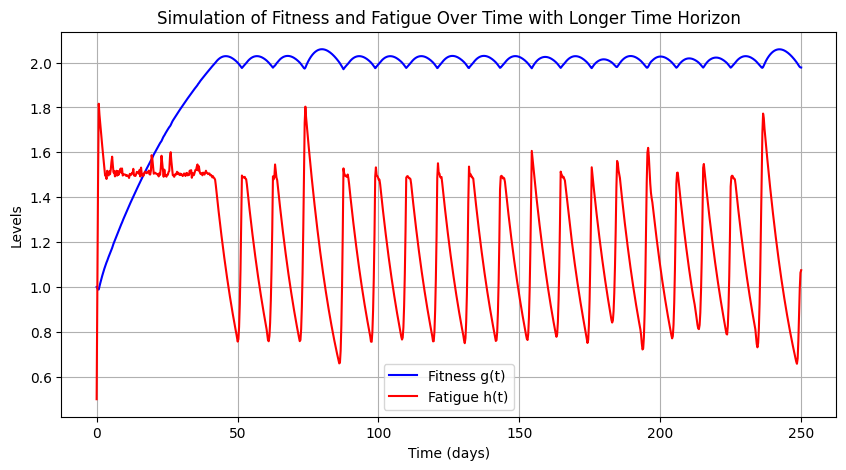

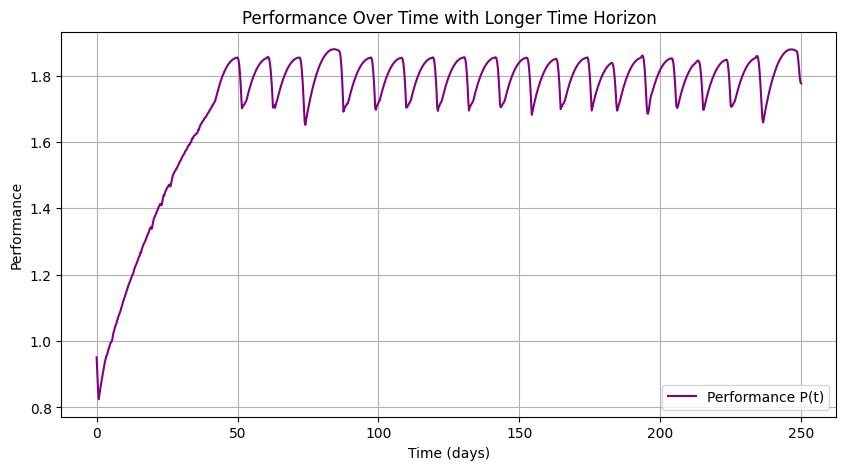

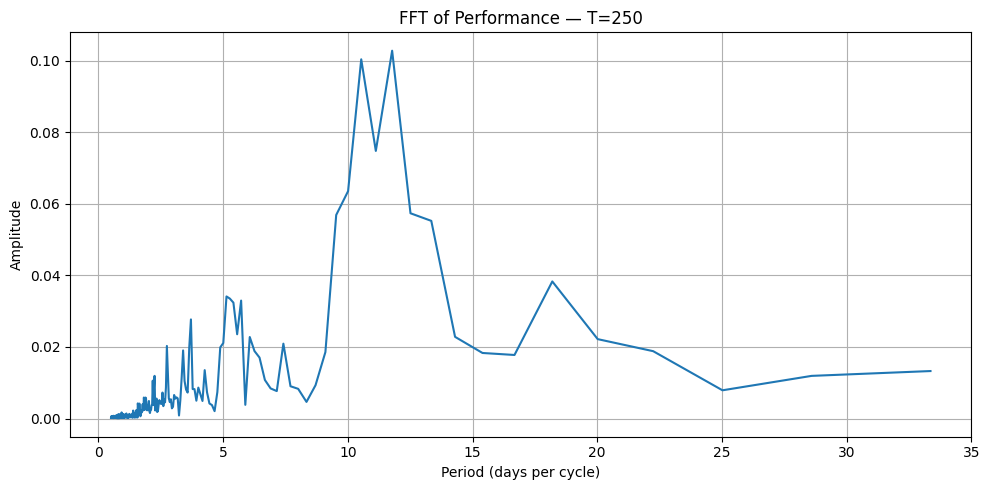

Dominant cycle length: 11.78 days


In [42]:
del g_opt, h_opt, time_opt, p, W_opt, V

T = 250
n_g, n_h, n_t = 50, 50, 250
g_max, h_max = 2.0, 1.5 
g_grid = np.linspace(0, g_max, n_g)
h_grid = np.linspace(0, h_max, n_h)
t_grid = np.linspace(0, T, n_t)
t_eval = np.linspace(0, T, 1000)
V = np.full((n_g, n_h, n_t), np.inf)
W_opt = np.zeros((n_g, n_h, n_t)) 

# Terminal condition for V at t = T
for i in range(n_g):
    for j in range(n_h):
        g, h = g_grid[i], h_grid[j]
        p = g * np.exp(-eta * h)
        V[i, j, -1] = p - p_desired

dt = T / (n_t - 1)
dg = g_grid[1] - g_grid[0]
dh = h_grid[1] - h_grid[0]

# HJB solver
# Forward computation of the value function and optimal control
for t_idx in range(0, n_t - 1):  # Start from t = 0
    for i in range(1, n_g - 1):  # 
        for j in range(1, n_h- 1):  # 
            # Gradients of V
            dV_dg = (V[i+1, j, t_idx] - V[i, j, t_idx]) / dg  # Forward difference in g
            dV_dh = (V[i, j+1, t_idx] - V[i, j, t_idx]) / dh  # Forward difference in h
            grad_V = np.array([dV_dg, dV_dh])

            # Hamiltonian components
            def F1(w): return k_a * h_grid[j] * (1 - w) - g_grid[i] / tau_a
            def F2(w): return k_f * w - h_grid[j] / tau_f

            # Maximize H to find optimal w
            w_opt = max(0, min(1, (grad_V[1] * k_f - grad_V[0] * k_a * h_grid[j]) / 2))
            W_opt[i, j, t_idx] = w_opt  # Store optimal w

            # Compute the dynamics using w_opt
            F = np.array([F1(w_opt), F2(w_opt)])
            C = w_opt**2  # Quadratic cost of training load

            # Update value function
            V[i, j, t_idx] = V[i, j, t_idx+1] + dt * (grad_V @ F - C)
            warnings.filterwarnings("ignore", category=RuntimeWarning)

# Interpolator for w_opt
interpolate_w_opt = RegularGridInterpolator((g_grid, h_grid, t_grid), W_opt, bounds_error=False, fill_value=0)

solution_opt = solve_ivp(forward_dynamics_with_optimal_w, (0, T), y0, t_eval=t_eval, args=(
    1, 2, 45, 12, eta, interpolate_w_opt)) 

time_opt = solution_opt.t
g_opt = solution_opt.y[0]
h_opt = solution_opt.y[1]

plt.figure(figsize=(10, 5))
plt.plot(time_opt, g_opt, label="Fitness g(t)", color="blue")
plt.plot(time_opt, h_opt, label="Fatigue h(t)", color="red")
plt.xlabel("Time (days)")
plt.ylabel("Levels")
plt.title("Simulation of Fitness and Fatigue Over Time with Longer Time Horizon")
plt.legend()
plt.grid(True)
plt.show()

def plot_performance(time, g, h, eta=.1):
    p = g * np.exp(-eta * h)

    # Plot performance
    plt.figure(figsize=(10, 5))
    plt.plot(time, p, label="Performance P(t)", color="purple")
    plt.xlabel("Time (days)")
    plt.ylabel("Performance")
    plt.title("Performance Over Time with Longer Time Horizon")
    plt.legend()
    plt.grid(True)
    plt.show()
    
p = g_opt * np.exp(-eta * h_opt)
plot_performance(time_opt, g_opt, h_opt)

plot_fft_of_performance(time_opt, p, label='T=250', start_time=50, max_period=40)